In [ ]:
# from pathlib import Path
# import pandas as pd
# import re

# # =========================
# # USER CONFIG
# # =========================
# IN_PATH  = Path("/Users/lvmeizhong/Downloads/edge_diamond_glide_set_dissociated.lmp")  # 改成你的路径
# OUT_PATH = IN_PATH.with_name(IN_PATH.stem + "_swapYZ.lmp")

# PAD = 1e-6          # 给 bounds 加一点点余量，防浮点误差
# FLOAT_FMT = "%.13f" # 输出坐标精度
# # =========================

# # --- 1) 找到 Atoms 段起始行号（用于 skiprows） ---
# with IN_PATH.open("r") as f:
#     lines = f.readlines()

# atoms_hdr_idx = None
# for i, l in enumerate(lines):
#     if l.strip().startswith("Atoms"):
#         atoms_hdr_idx = i
#         break
# assert atoms_hdr_idx is not None, "没找到 'Atoms' 段"

# # Atoms header 下一行通常是空行；原子数据从 atoms_hdr_idx+2 开始
# atoms_data_start = atoms_hdr_idx + 2

# # --- 2) 读 Atoms（你的文件是 Atoms # atomic: id type x y z） ---
# df = pd.read_csv(
#     IN_PATH,
#     delim_whitespace=True,
#     header=None,
#     names=["id", "type", "x", "y", "z"],
#     skiprows=atoms_data_start,
#     comment="#",
#     engine="python",
# )

# # --- 3) swap：把现在的 Y 当 Z，把现在的 Z 当 Y（y<->z） ---
# df_sw = df.copy()
# df_sw["y"], df_sw["z"] = df["z"], df["y"]

# # --- 4) 重新计算交换后的 box bounds（关键：避免越界 wrap 导致“对不齐”） ---
# xlo, xhi = df_sw["x"].min() - PAD, df_sw["x"].max() + PAD
# ylo, yhi = df_sw["y"].min() - PAD, df_sw["y"].max() + PAD
# zlo, zhi = df_sw["z"].min() - PAD, df_sw["z"].max() + PAD

# # --- 5) 重写文件：保留原 header/sections，只替换 xlo/xhi,ylo/yhi,zlo/zhi，并写新的 Atoms ---
# re_x = re.compile(r"^\s*([+-]?\d.*)\s+([+-]?\d.*)\s+xlo\s+xhi\s*$")
# re_y = re.compile(r"^\s*([+-]?\d.*)\s+([+-]?\d.*)\s+ylo\s+yhi\s*$")
# re_z = re.compile(r"^\s*([+-]?\d.*)\s+([+-]?\d.*)\s+zlo\s+zhi\s*$")

# with OUT_PATH.open("w") as out:
#     # 5.1 写 header 到 Atoms header 行（含 Masses 等都原样保留，但 bounds 行替换）
#     for i in range(atoms_hdr_idx + 1):  # 包含 "Atoms  # atomic" 这一行
#         l = lines[i].rstrip("\n")
#         if re_x.match(l):
#             out.write(f"{xlo:{''}.15f} {xhi:{''}.15f} xlo xhi\n")
#         elif re_y.match(l):
#             out.write(f"{ylo:{''}.15f} {yhi:{''}.15f} ylo yhi\n")
#         elif re_z.match(l):
#             out.write(f"{zlo:{''}.15f} {zhi:{''}.15f} zlo zhi\n")
#         else:
#             out.write(lines[i])

#     # 5.2 确保 Atoms header 后有一个空行（按原文件格式）
#     if atoms_hdr_idx + 1 < len(lines) and lines[atoms_hdr_idx + 1].strip() != "":
#         out.write("\n")

#     # 5.3 写 Atoms 数据（id type x y z）
#     #     注意：id/type 保持整数，坐标用 FLOAT_FMT
#     df_out = df_sw[["id", "type", "x", "y", "z"]].copy()
#     df_out["id"] = df_out["id"].astype(int)
#     df_out["type"] = df_out["type"].astype(int)

#     df_out.to_csv(
#         out,
#         sep=" ",
#         header=False,
#         index=False,
#         float_format=FLOAT_FMT,
#     )

# print("Wrote:", OUT_PATH)
# print("New bounds:")
# print("xlo xhi:", xlo, xhi)
# print("ylo yhi:", ylo, yhi)
# print("zlo zhi:", zlo, zhi)


/Users/lvmeizhong/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/lvmeizhong/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/var/folders/06/hmnjzdgn7vgcwblryw9g856c0000gn/T/ipykernel_29051/1906020755.py:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


Wrote: /Users/lvmeizhong/Downloads/edge_diamond_glide_set_dissociated_swapYZ.lmp
New bounds:
xlo xhi: -75.0470767729 73.787668008
ylo yhi: -74.7199654502 82.6373232656
zlo zhi: -74.14077634019999 73.6231741509


In [7]:
from pathlib import Path
import pandas as pd
import re

# =========================
# USER CONFIG
# =========================
IN_PATH  = Path("/Users/lvmeizhong/Downloads/edge_diamond_glide_set.lmp")
OUT_PATH = IN_PATH.with_name(IN_PATH.stem + "_swapYZ.lmp")

PAD = 1e-6
FLOAT_FMT = "%.13f"
# =========================

with IN_PATH.open("r") as f:
    lines = f.readlines()

# --- NEW: parse natoms from header (one added block) ---
natoms = None
re_natoms = re.compile(r"^\s*(\d+)\s+atoms\s*$")
for l in lines[:2000]:  # header 一般很短，扫前 2000 行足够
    m = re_natoms.match(l.strip())
    if m:
        natoms = int(m.group(1))
        break
assert natoms is not None, "Header 里没找到 'N atoms'"

# --- 1) 找到 Atoms 段起始行号 ---
atoms_hdr_idx = None
for i, l in enumerate(lines):
    if l.strip().startswith("Atoms"):
        atoms_hdr_idx = i
        break
assert atoms_hdr_idx is not None, "没找到 'Atoms' 段"

atoms_data_start = atoms_hdr_idx + 2  # 假设 Atoms header 后有空行

# --- 2) 读 Atoms：关键是一行 nrows=natoms（就这行最重要） ---
df = pd.read_csv(
    IN_PATH,
    delim_whitespace=True,
    header=None,
    names=["id", "type", "x", "y", "z"],
    skiprows=atoms_data_start,
    nrows=natoms,              # <<< 关键：只读 natoms 行 :contentReference[oaicite:3]{index=3}
    comment="#",
    engine="python",
)

# --- 3) swap y<->z ---
df_sw = df.copy()
df_sw["y"], df_sw["z"] = df["z"], df["y"]

# --- 4) 重新计算 bounds ---
xlo, xhi = df_sw["x"].min() - PAD, df_sw["x"].max() + PAD
ylo, yhi = df_sw["y"].min() - PAD, df_sw["y"].max() + PAD
zlo, zhi = df_sw["z"].min() - PAD, df_sw["z"].max() + PAD

re_x = re.compile(r"^\s*([+-]?\d.*)\s+([+-]?\d.*)\s+xlo\s+xhi\s*$")
re_y = re.compile(r"^\s*([+-]?\d.*)\s+([+-]?\d.*)\s+ylo\s+yhi\s*$")
re_z = re.compile(r"^\s*([+-]?\d.*)\s+([+-]?\d.*)\s+zlo\s+zhi\s*$")

with OUT_PATH.open("w") as out:
    # 写 header 到 Atoms header 行（含 Atoms 行本身）
    for i in range(atoms_hdr_idx + 1):
        l = lines[i].rstrip("\n")
        if re_x.match(l):
            out.write(f"{xlo:.15f} {xhi:.15f} xlo xhi\n")
        elif re_y.match(l):
            out.write(f"{ylo:.15f} {yhi:.15f} ylo yhi\n")
        elif re_z.match(l):
            out.write(f"{zlo:.15f} {zhi:.15f} zlo zhi\n")
        else:
            out.write(lines[i])

    # 更稳：无条件补一个空行（LAMMPS 数据文件空行很重要）:contentReference[oaicite:4]{index=4}
    out.write("\n")

    df_out = df_sw[["id", "type", "x", "y", "z"]].copy()
    df_out["id"] = df_out["id"].astype(int)
    df_out["type"] = df_out["type"].astype(int)

    df_out.to_csv(out, sep=" ", header=False, index=False, float_format=FLOAT_FMT)

    # 关键：把原文件 Atoms 段后面的内容原样接回去（如果有的话）
    rest_start = atoms_data_start + natoms
    out.write("\n")
    out.writelines(lines[rest_start:])

print("Wrote:", OUT_PATH)
print("natoms:", natoms)


/var/folders/06/hmnjzdgn7vgcwblryw9g856c0000gn/T/ipykernel_29051/3669369442.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


Wrote: /Users/lvmeizhong/Downloads/edge_diamond_glide_set_swapYZ.lmp
natoms: 616824


In [3]:
%pip install -e ~/Desktop/expoly-with-legacy/EXPoly

Obtaining file:///Users/lvmeizhong/Desktop/expoly-with-legacy/EXPoly
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for expoly (pyproject.toml) ... done
  Created wheel for expoly: filename=expoly-0.2.0-0.editable-py3-none-any.whl size=4073 sha256=15047fd1d5ddd3928f6b632fbfd8cf85faf787e43b83f1028b98c0b200efba42
  Stored in directory: /private/var/folders/06/hmnjzdgn7vgcwblryw9g856c0000gn/T/pip-ephem-wheel-cache-t3k75nr5/wheels/c9/86/c1/233413da03f4c5cbd75821181fa7b94718d0e3cde198cd33e3
Successfully built expoly
  Attempting uninstall: expoly
    Found existing installation: expoly 0.2.0
    Uninstalling expoly-0.2.0:
      Successfully uninstalled expoly-0.2.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
from pathlib import Path
import sys
import numpy as np
import h5py as hdf

# =========================
# USER CONFIG
# =========================
DREAM3D_PATH = Path("/Users/lvmeizhong/Downloads/t0_Meshed_MoreFeature.dream3d")

# 你要的范围：按 Python slice 语义 [start, end)
HX0, HX1 = 70, 200
HY0, HY1 = 70, 200
HZ0, HZ1 = 150, 500

OUT_CSV = DREAM3D_PATH.with_suffix("").with_name(
    f"{DREAM3D_PATH.stem}_hx{HX0}-{HX1}_hy{HY0}-{HY1}_hz{HZ0}-{HZ1}.csv"
)

# 如果你没有 pip install -e，填你的 EXPoly/src 路径；否则可留 None
EXPOLY_SRC = Path("/Users/lvmeizhong/Desktop/expoly-with-legacy/EXPoly/src")  # <- 改成你的；已安装则可注释掉
# =========================

# ---- import helper from your expoly.frames (needs package import to satisfy relative imports) ----
if EXPOLY_SRC and EXPOLY_SRC.exists():
    sys.path.insert(0, str(EXPOLY_SRC))

from expoly.frames import find_dataset_keys  # :contentReference[oaicite:4]{index=4}

PREFER = ["CellData", "CellFeatureData", "_SIMPL_GEOMETRY"]

def _get_dataset(f: hdf.File, basename: str):
    keys = find_dataset_keys(f, basename, prefer_groups=PREFER)  # :contentReference[oaicite:5]{index=5}
    obj = f
    for k in keys:
        obj = obj[k]
    return obj, "/".join(keys)

def _pick_grainid_dataset(f: hdf.File):
    # 你遇到过的几种常见名字都试一下；找到第一个就用
    for name in ["FeatureIds", "GrainID", "GrainId", "GrainIds", "grain-ID"]:
        try:
            dset, path = _get_dataset(f, name)
            return dset, path, name
        except KeyError:
            pass
    raise KeyError("找不到 GrainId dataset：尝试过 FeatureIds/GrainID/GrainId/...；请先列一下 HDF5 keys。")

# ---- main: open HDF5 and stream-write cropped voxels ----
with hdf.File(DREAM3D_PATH, "r") as f:
    dim_dset, dim_path = _get_dataset(f, "DIMENSIONS")
    dim = np.asarray(dim_dset[()]).reshape(-1)
    if dim.size < 3:
        raise ValueError(f"DIMENSIONS looks wrong: {dim} (path={dim_path})")

    # Dream3D: dimensions are X, Y, Z :contentReference[oaicite:6]{index=6}
    HX, HY, HZ = int(dim[0]), int(dim[1]), int(dim[2])

    # bounds check
    assert 0 <= HX0 < HX1 <= HX, (HX0, HX1, HX)
    assert 0 <= HY0 < HY1 <= HY, (HY0, HY1, HY)
    assert 0 <= HZ0 < HZ1 <= HZ, (HZ0, HZ1, HZ)

    gid_dset, gid_path, gid_name = _pick_grainid_dataset(f)

    print("DIMENSIONS path:", dim_path, " -> (HX,HY,HZ)=", (HX,HY,HZ))
    print("GrainId dataset:", gid_name, "path:", gid_path, "shape:", gid_dset.shape, "dtype:", gid_dset.dtype)

    # ---- write CSV (space-delimited) ----
    # 5,915,000 行会很大；这里用按行批量写，避免 csv.writer 的 per-row 开销
    with OUT_CSV.open("w") as out:
        out.write("HZ HY HX grain-ID\n")

        hx_vals = np.arange(HX0, HX1, dtype=np.int32)

        # Case A: 1D flattened dataset (very common): length == HX*HY*HZ
        if gid_dset.ndim == 1:
            if gid_dset.size != HX * HY * HZ:
                raise ValueError(f"1D GrainId size={gid_dset.size} != HX*HY*HZ={HX*HY*HZ} (check DIMENSIONS?)")

            # Flatten index for (hz,hy,hx) in C-order on (HZ,HY,HX):
            # idx = (hz*HY + hy)*HX + hx
            row_len = HX1 - HX0
            for hz in range(HZ0, HZ1):
                base_hz = hz * HY * HX
                for hy in range(HY0, HY1):
                    start = base_hz + hy * HX + HX0
                    end   = start + row_len
                    gids = gid_dset[start:end]  # hyperslab slice :contentReference[oaicite:7]{index=7}
                    # batch write one HY row
                    lines = [f"{hz} {hy} {hx} {int(g)}\n" for hx, g in zip(hx_vals, gids)]
                    out.writelines(lines)

        # Case B: 3D dataset: assume it is (HZ,HY,HX) or (HX,HY,HZ)
        elif gid_dset.ndim == 3:
            sh = gid_dset.shape
            # Most Dream3D image data is effectively Z,Y,X in memory/tuple order :contentReference[oaicite:8]{index=8}
            if sh == (HZ, HY, HX):
                for hz in range(HZ0, HZ1):
                    slab = gid_dset[hz, HY0:HY1, HX0:HX1]  # hyperslab slice :contentReference[oaicite:9]{index=9}
                    for iy, hy in enumerate(range(HY0, HY1)):
                        gids = slab[iy, :]
                        lines = [f"{hz} {hy} {hx} {int(g)}\n" for hx, g in zip(hx_vals, gids)]
                        out.writelines(lines)
            elif sh == (HX, HY, HZ):
                # transpose on the fly: gid[hx,hy,hz]
                for hz in range(HZ0, HZ1):
                    slab = gid_dset[HX0:HX1, HY0:HY1, hz]  # -> (hx,hy)
                    for iy, hy in enumerate(range(HY0, HY1)):
                        gids = slab[:, iy]
                        lines = [f"{hz} {hy} {hx} {int(g)}\n" for hx, g in zip(hx_vals, gids)]
                        out.writelines(lines)
            else:
                raise ValueError(f"Unexpected 3D GrainId shape={sh}; expected {(HZ,HY,HX)} or {(HX,HY,HZ)}")

        # Case C: 4D dataset (HZ,HY,HX,1) is also seen sometimes
        elif gid_dset.ndim == 4 and gid_dset.shape[-1] == 1 and gid_dset.shape[:3] == (HZ, HY, HX):
            for hz in range(HZ0, HZ1):
                slab = gid_dset[hz, HY0:HY1, HX0:HX1, 0]
                for iy, hy in enumerate(range(HY0, HY1)):
                    gids = slab[iy, :]
                    lines = [f"{hz} {hy} {hx} {int(g)}\n" for hx, g in zip(hx_vals, gids)]
                    out.writelines(lines)

        else:
            raise ValueError(f"Unsupported GrainId ndim/shape: ndim={gid_dset.ndim}, shape={gid_dset.shape}")

print("Wrote:", OUT_CSV)
print("Kept voxels =", (HX1 - HX0) * (HY1 - HY0) * (HZ1 - HZ0))


DIMENSIONS path: DataContainers/GM3D/_SIMPL_GEOMETRY/DIMENSIONS  -> (HX,HY,HZ)= (259, 277, 1133)
GrainId dataset: GrainID path: DataContainers/GM3D/CellData/GrainID shape: (1133, 277, 259, 1) dtype: int32
Wrote: /Users/lvmeizhong/Downloads/t0_Meshed_MoreFeature_hx70-200_hy70-200_hz150-500.csv
Kept voxels = 5915000


In [5]:
from pathlib import Path
import numpy as np
import pandas as pd
from collections import Counter

# =========================
# USER CONFIG
# =========================
IN_CSV  = Path("/Users/lvmeizhong/Downloads/t0_Meshed_MoreFeature_hx70-200_hy70-200_hz150-500.csv")
OUT_CSV = IN_CSV.with_name(IN_CSV.stem + "_filled.csv")

# 列名（你之前导出的是：HZ HY HX grain-ID）
COL_Z, COL_Y, COL_X, COL_ID = "HZ", "HY", "HX", "grain-ID"

# 安全阈值：防止死循环（一般不会触发；设大一点即可）
MAX_ITERS = 10_000
# =========================

# ---------- 1) read csv ----------
df = pd.read_csv(IN_CSV, delim_whitespace=True, engine="python")
for c in [COL_Z, COL_Y, COL_X, COL_ID]:
    if c not in df.columns:
        raise KeyError(f"Missing column {c}. Got columns={list(df.columns)}")

hz = df[COL_Z].to_numpy(np.int32)
hy = df[COL_Y].to_numpy(np.int32)
hx = df[COL_X].to_numpy(np.int32)
gid = df[COL_ID].to_numpy(np.int64)

# 子块的绝对坐标范围（用来恢复到 array index）
z0, z1 = int(hz.min()), int(hz.max())
y0, y1 = int(hy.min()), int(hy.max())
x0, x1 = int(hx.min()), int(hx.max())

Z = z1 - z0 + 1
Y = y1 - y0 + 1
X = x1 - x0 + 1

grid = np.zeros((Z, Y, X), dtype=np.int64)

# 填入已有 id
grid[hz - z0, hy - y0, hx - x0] = gid

print("Loaded grid shape (Z,Y,X) =", grid.shape)
print("Nonzero voxels =", int((grid != 0).sum()), "/", grid.size)

# ---------- helpers ----------
# 6 邻域 offsets（上下左右前后）
OFF6 = np.array([
    (-1, 0, 0),
    ( 1, 0, 0),
    ( 0,-1, 0),
    ( 0, 1, 0),
    ( 0, 0,-1),
    ( 0, 0, 1),
], dtype=np.int32)

# 26 邻域 offsets（包含斜对角），去掉 (0,0,0)
OFF26 = []
for dz in (-1,0,1):
    for dy in (-1,0,1):
        for dx in (-1,0,1):
            if dz == dy == dx == 0:
                continue
            OFF26.append((dz,dy,dx))
OFF26 = np.array(OFF26, dtype=np.int32)

def vote_majority(vals: np.ndarray):
    """vals: (k,) 邻域 id，包含 0。返回: (label, is_tie)"""
    v = vals[vals != 0]
    if v.size == 0:
        return 0, False
    cnt = Counter(v.tolist())
    maxc = max(cnt.values())
    winners = [lab for lab, c in cnt.items() if c == maxc]
    if len(winners) == 1:
        return winners[0], False
    # 仍然平票：返回 tie，让上层决定进一步看 26 邻域；如果最终还平票就取最小值（确定性）
    return min(winners), True

def neighbors_from_src(src_pad: np.ndarray, coords_pad: np.ndarray, offsets: np.ndarray):
    """
    src_pad: padded grid, shape (Z+2,Y+2,X+2)
    coords_pad: (M,3) padded coords
    offsets: (K,3)
    return: (M,K) neighbor labels
    """
    M = coords_pad.shape[0]
    K = offsets.shape[0]
    out = np.empty((M, K), dtype=src_pad.dtype)
    z = coords_pad[:,0]; y = coords_pad[:,1]; x = coords_pad[:,2]
    for k in range(K):
        dz, dy, dx = offsets[k]
        out[:,k] = src_pad[z+dz, y+dy, x+dx]
    return out

# ---------- 2) wavefront fill ----------
gpad = np.pad(grid, pad_width=1, mode="constant", constant_values=0)

filled_total = 0
for it in range(1, MAX_ITERS + 1):
    src = gpad.copy()  # 关键：本轮“同时更新”，避免顺序偏置

    core = src[1:-1, 1:-1, 1:-1]
    zero = (core == 0)

    # 是否有 6 邻域非零
    n6 = np.stack([
        src[0:-2, 1:-1, 1:-1],
        src[2:  , 1:-1, 1:-1],
        src[1:-1, 0:-2, 1:-1],
        src[1:-1, 2:  , 1:-1],
        src[1:-1, 1:-1, 0:-2],
        src[1:-1, 1:-1, 2:  ],
    ], axis=0)

    cand = zero & (n6 != 0).any(axis=0)  # 当前波前（距离已知区域最近的一层 0）

    if not cand.any():
        break

    # cand coords in core coordinates -> pad coordinates (+1)
    coords = np.argwhere(cand).astype(np.int32)
    coords_pad = coords + 1  # (M,3) in padded space

    # 先用 6 邻域投票
    lab6 = neighbors_from_src(src, coords_pad, OFF6)  # (M,6)
    new_labels = np.empty((coords.shape[0],), dtype=np.int64)
    need_26 = np.zeros((coords.shape[0],), dtype=bool)

    for i in range(coords.shape[0]):
        lab, tie = vote_majority(lab6[i])
        new_labels[i] = lab
        need_26[i] = tie or (lab == 0)

    # 对平票/无法判断的，升级到 26 邻域再投票
    if need_26.any():
        coords_pad2 = coords_pad[need_26]
        lab26 = neighbors_from_src(src, coords_pad2, OFF26)  # (M2,26)
        idxs = np.where(need_26)[0]
        for j, i in enumerate(idxs):
            lab, _tie = vote_majority(lab26[j])
            # 若 26 邻域仍全是 0（理论上不会发生在 wavefront），就保持 0，下一轮再填
            new_labels[i] = lab

    # 写回本轮结果（只写那些决定出非零的）
    ok = (new_labels != 0)
    if ok.any():
        cz = coords_pad[ok,0]; cy = coords_pad[ok,1]; cx = coords_pad[ok,2]
        gpad[cz, cy, cx] = new_labels[ok]
        filled_total += int(ok.sum())

    if it % 10 == 0:
        remain = int((gpad[1:-1,1:-1,1:-1] == 0).sum())
        print(f"[iter {it}] newly_filled={int(ok.sum())}, remain_zeros={remain}")

grid_filled = gpad[1:-1, 1:-1, 1:-1]
remain = int((grid_filled == 0).sum())
print("Done. filled_total =", filled_total, "| remain_zeros =", remain)

# ---------- 3) write filled csv ----------
# 生成全部坐标（Z*Y*X 行，可能很大；但你这块大约 5.9M 行，写 CSV 是可行的）
zz, yy, xx = np.indices(grid_filled.shape, dtype=np.int32)
out_df = pd.DataFrame({
    COL_Z: zz.ravel() + z0,
    COL_Y: yy.ravel() + y0,
    COL_X: xx.ravel() + x0,
    COL_ID: grid_filled.ravel().astype(np.int64),
})

out_df.to_csv(OUT_CSV, sep=" ", index=False)
print("Wrote:", OUT_CSV)


/var/folders/06/hmnjzdgn7vgcwblryw9g856c0000gn/T/ipykernel_86704/1956593059.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(IN_CSV, delim_whitespace=True, engine="python")


Loaded grid shape (Z,Y,X) = (350, 130, 130)
Nonzero voxels = 5905848 / 5915000
Done. filled_total = 9152 | remain_zeros = 0
Wrote: /Users/lvmeizhong/Downloads/t0_Meshed_MoreFeature_hx70-200_hy70-200_hz150-500_filled.csv


/var/folders/06/hmnjzdgn7vgcwblryw9g856c0000gn/T/ipykernel_86704/1388703300.py:42: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for i, chunk in enumerate(pd.read_csv(path, delim_whitespace=True, usecols=usecols, dtype=dtypes,
/var/folders/06/hmnjzdgn7vgcwblryw9g856c0000gn/T/ipykernel_86704/1388703300.py:42: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for i, chunk in enumerate(pd.read_csv(path, delim_whitespace=True, usecols=usecols, dtype=dtypes,


[before] sampled zero=9152, nonzero=50000
[after ] sampled zero=0, nonzero=50000


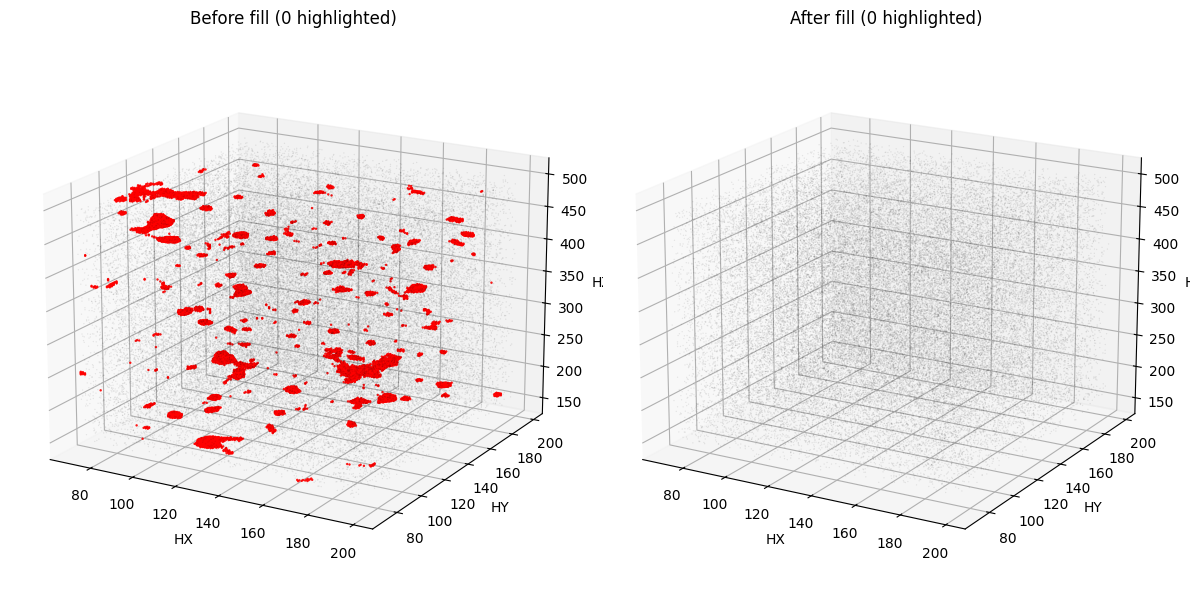

In [6]:
# %matplotlib widget   # 想交互旋转就打开这一行（本地 Jupyter 通常好用）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# USER CONFIG
# =========================
CSV_BEFORE = "/Users/lvmeizhong/Downloads/t0_Meshed_MoreFeature_hx70-200_hy70-200_hz150-500.csv"
CSV_AFTER  = "/Users/lvmeizhong/Downloads/t0_Meshed_MoreFeature_hx70-200_hy70-200_hz150-500_filled.csv"

# 采样数量（画图用，不影响真实数据）
N_ZERO_BEFORE   = 50000
N_NONZERO_BEFORE= 50000
N_ZERO_AFTER    = 50000
N_NONZERO_AFTER = 50000

CHUNKSIZE = 300_000     # 每次读多少行（按机器内存调）
SEED = 0

# 列名（你导出的是空格分隔）
COL_Z, COL_Y, COL_X, COL_ID = "HZ", "HY", "HX", "grain-ID"

# 画图参数
S_ZERO = 3
S_NONZERO = 1
ALPHA_ZERO = 0.9
ALPHA_NONZERO = 0.08
# =========================

def _sample_from_csv(path, n_zero, n_nonzero, chunksize=300_000, seed=0):
    rng = np.random.default_rng(seed)
    usecols = [COL_Z, COL_Y, COL_X, COL_ID]
    dtypes  = {COL_Z: np.int32, COL_Y: np.int32, COL_X: np.int32, COL_ID: np.int64}

    keep_zero = []
    keep_nz   = []
    need_zero = n_zero
    need_nz   = n_nonzero

    # 分块读 + 每块内随机抽一点，最后再统一抽到目标数量
    for i, chunk in enumerate(pd.read_csv(path, delim_whitespace=True, usecols=usecols, dtype=dtypes,
                                          engine="python", chunksize=chunksize)):
        zmask = (chunk[COL_ID].to_numpy() == 0)
        nzmask = ~zmask

        cz = chunk.loc[zmask]
        cnz = chunk.loc[nzmask]

        # 每块最多抽“还缺的两倍”以增加随机性，然后后面再整体 downsample
        if need_zero > 0 and len(cz) > 0:
            take = min(len(cz), max(1000, 2 * need_zero))
            keep_zero.append(cz.sample(n=take, random_state=int(rng.integers(1<<31))))

        if need_nz > 0 and len(cnz) > 0:
            take = min(len(cnz), max(1000, 2 * need_nz))
            keep_nz.append(cnz.sample(n=take, random_state=int(rng.integers(1<<31))))

        # 提前终止：如果累计已经远超所需，就可以停（可加速）
        # 这里简单保守：跑完整个文件也没问题，只是慢一点
        if i % 10 == 0:
            pass

    if keep_zero:
        dz = pd.concat(keep_zero, ignore_index=True)
        dz = dz.sample(n=min(n_zero, len(dz)), random_state=seed) if len(dz) > n_zero else dz
    else:
        dz = pd.DataFrame(columns=usecols)

    if keep_nz:
        dnz = pd.concat(keep_nz, ignore_index=True)
        dnz = dnz.sample(n=min(n_nonzero, len(dnz)), random_state=seed) if len(dnz) > n_nonzero else dnz
    else:
        dnz = pd.DataFrame(columns=usecols)

    return dz, dnz

def _plot(ax, dz, dnz, title):
    # 非零：灰色淡背景
    if len(dnz) > 0:
        ax.scatter(dnz[COL_X], dnz[COL_Y], dnz[COL_Z],
                   s=S_NONZERO, alpha=ALPHA_NONZERO, c="k", linewidths=0)

    # 0：红色高亮
    if len(dz) > 0:
        ax.scatter(dz[COL_X], dz[COL_Y], dz[COL_Z],
                   s=S_ZERO, alpha=ALPHA_ZERO, c="r", linewidths=0)

    ax.set_title(title)
    ax.set_xlabel("HX")
    ax.set_ylabel("HY")
    ax.set_zlabel("HZ")
    ax.view_init(elev=18, azim=-60)

# ---- sample ----
dz0, dnz0 = _sample_from_csv(CSV_BEFORE, N_ZERO_BEFORE, N_NONZERO_BEFORE, chunksize=CHUNKSIZE, seed=SEED)
dz1, dnz1 = _sample_from_csv(CSV_AFTER,  N_ZERO_AFTER,  N_NONZERO_AFTER,  chunksize=CHUNKSIZE, seed=SEED+1)

print(f"[before] sampled zero={len(dz0)}, nonzero={len(dnz0)}")
print(f"[after ] sampled zero={len(dz1)}, nonzero={len(dnz1)}")

# ---- plot side-by-side ----
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")

_plot(ax1, dz0, dnz0, "Before fill (0 highlighted)")
_plot(ax2, dz1, dnz1, "After fill (0 highlighted)")

plt.tight_layout()
plt.show()


/var/folders/06/hmnjzdgn7vgcwblryw9g856c0000gn/T/ipykernel_86704/1510475096.py:40: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(csv_path, delim_whitespace=True, usecols=usecols, dtype=dtypes,
/var/folders/06/hmnjzdgn7vgcwblryw9g856c0000gn/T/ipykernel_86704/1510475096.py:56: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(csv_path, delim_whitespace=True, usecols=usecols, dtype=dtypes,
/var/folders/06/hmnjzdgn7vgcwblryw9g856c0000gn/T/ipykernel_86704/1510475096.py:40: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(csv_path, delim_whitespace=True, usecols=usecols, dtype=dtypes,
/var/folders/06/hmnjzdgn7vgcwblryw9g856c0000gn/T/ipy

Grid shape (Z,Y,X): (350, 130, 130) origin(abs z,y,x): (150, 70, 70)
Zeros before: 9152 | after: 0
Picked window: z[310:350) y[0:50) x[0:50) | zero_cnt=1660
Color scale: vmin= 64 vmax= 999


/var/folders/06/hmnjzdgn7vgcwblryw9g856c0000gn/T/ipykernel_86704/1510475096.py:191: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


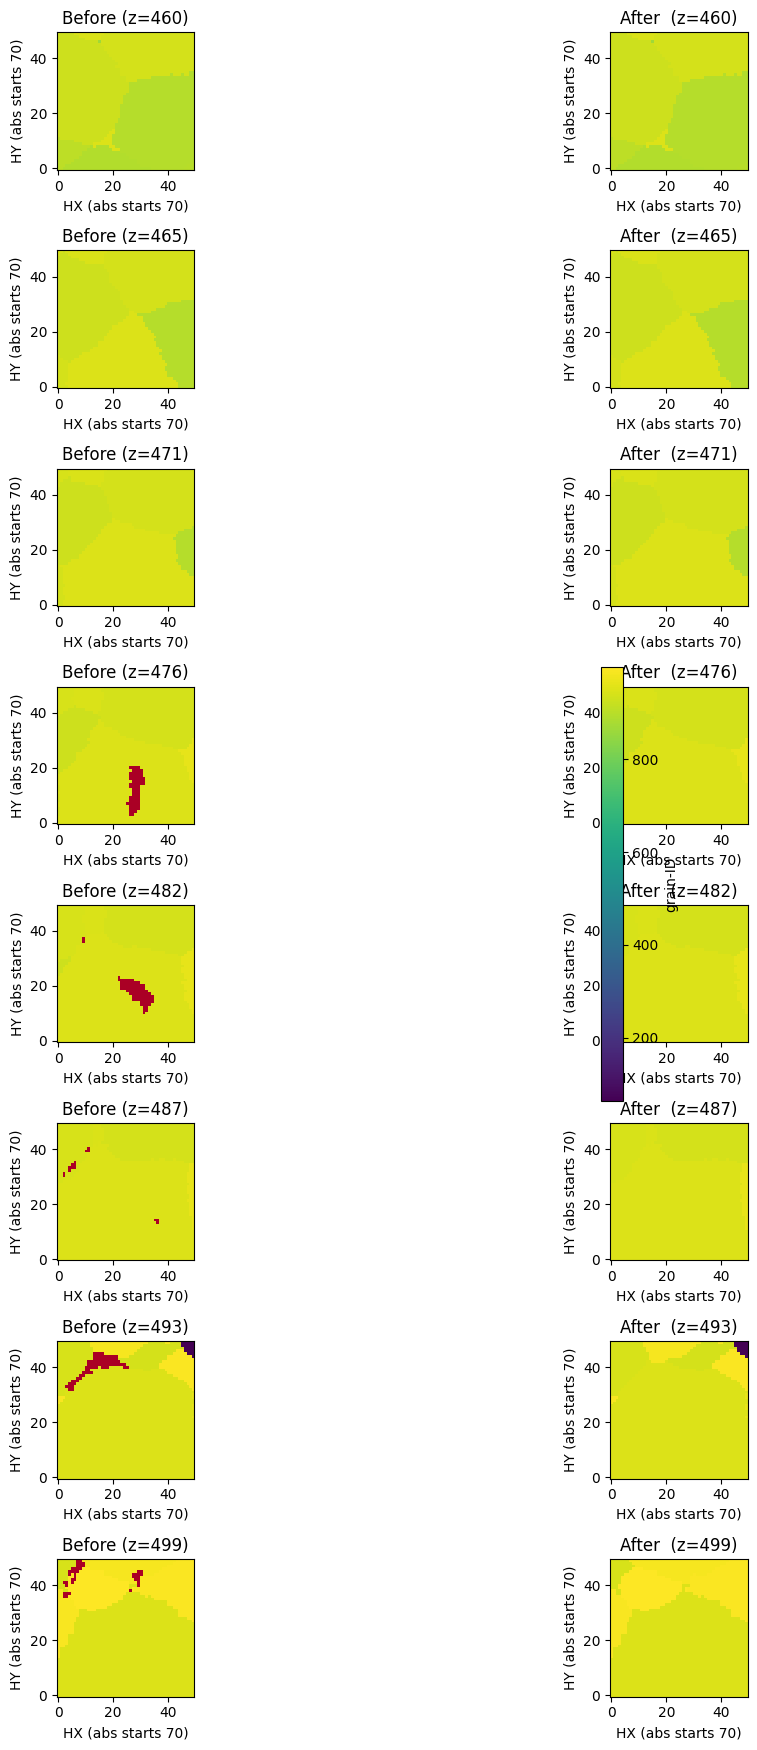

In [8]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.cm import ScalarMappable

# =========================
# USER CONFIG
# =========================
CSV_BEFORE = Path("/Users/lvmeizhong/Downloads/t0_Meshed_MoreFeature_hx70-200_hy70-200_hz150-500.csv")
CSV_AFTER  = Path("/Users/lvmeizhong/Downloads/t0_Meshed_MoreFeature_hx70-200_hy70-200_hz150-500_filled.csv")

COL_Z, COL_Y, COL_X, COL_ID = "HZ", "HY", "HX", "grain-ID"
CHUNKSIZE = 600_000

WIN_Z, WIN_Y, WIN_X = 40, 50, 50
STRIDE_Z, STRIDE_Y, STRIDE_X = 10, 10, 10
N_SLICES = 8

OVERLAY_ALPHA = 0.55
FIG_W = 14
FIG_H_PER_ROW = 2.2

# 统一色标方式：
# 1) "minmax" 用窗口内全局 min/max（最直观）
# 2) "nonzero_minmax" 忽略 0 后用非零 min/max（0 仍会显示为最小色，但会被红色 overlay 高亮）
COLOR_MODE = "nonzero_minmax"
CMAP = "viridis"
# =========================


def two_pass_load_grid(csv_path: Path):
    usecols = [COL_Z, COL_Y, COL_X, COL_ID]
    dtypes  = {COL_Z: np.int32, COL_Y: np.int32, COL_X: np.int32, COL_ID: np.int64}

    zmin = ymin = xmin = None
    zmax = ymax = xmax = None

    for chunk in pd.read_csv(csv_path, delim_whitespace=True, usecols=usecols, dtype=dtypes,
                             chunksize=CHUNKSIZE, engine="python"):
        czmin, cymin, cxmin = int(chunk[COL_Z].min()), int(chunk[COL_Y].min()), int(chunk[COL_X].min())
        czmax, cymax, cxmax = int(chunk[COL_Z].max()), int(chunk[COL_Y].max()), int(chunk[COL_X].max())
        zmin = czmin if zmin is None else min(zmin, czmin)
        ymin = cymin if ymin is None else min(ymin, cymin)
        xmin = cxmin if xmin is None else min(xmin, cxmin)
        zmax = czmax if zmax is None else max(zmax, czmax)
        ymax = cymax if ymax is None else max(ymax, cymax)
        xmax = cxmax if xmax is None else max(xmax, cxmax)

    Z = zmax - zmin + 1
    Y = ymax - ymin + 1
    X = xmax - xmin + 1
    grid = np.zeros((Z, Y, X), dtype=np.int64)

    for chunk in pd.read_csv(csv_path, delim_whitespace=True, usecols=usecols, dtype=dtypes,
                             chunksize=CHUNKSIZE, engine="python"):
        zz = chunk[COL_Z].to_numpy() - zmin
        yy = chunk[COL_Y].to_numpy() - ymin
        xx = chunk[COL_X].to_numpy() - xmin
        vv = chunk[COL_ID].to_numpy()
        grid[zz, yy, xx] = vv

    return grid, (zmin, ymin, xmin)


def prefix_sum_3d(mask01: np.ndarray) -> np.ndarray:
    return mask01.cumsum(0).cumsum(1).cumsum(2)


def box_sum(S: np.ndarray, z0, y0, x0, z1, y1, x1):
    def at(z, y, x):
        if z < 0 or y < 0 or x < 0:
            return 0
        return S[z, y, x]

    za, ya, xa = z0 - 1, y0 - 1, x0 - 1
    zb, yb, xb = z1 - 1, y1 - 1, x1 - 1
    return (
        at(zb, yb, xb)
        - at(za, yb, xb) - at(zb, ya, xb) - at(zb, yb, xa)
        + at(za, ya, xb) + at(za, yb, xa) + at(zb, ya, xa)
        - at(za, ya, xa)
    )


def find_most_zero_window(grid_before: np.ndarray):
    Z, Y, X = grid_before.shape
    wz, wy, wx = WIN_Z, WIN_Y, WIN_X
    zero = (grid_before == 0).astype(np.int32)
    S = prefix_sum_3d(zero)

    best_cnt = -1
    best = None
    for z0 in range(0, Z - wz + 1, STRIDE_Z):
        z1 = z0 + wz
        for y0 in range(0, Y - wy + 1, STRIDE_Y):
            y1 = y0 + wy
            for x0 in range(0, X - wx + 1, STRIDE_X):
                x1 = x0 + wx
                c = box_sum(S, z0, y0, x0, z1, y1, x1)
                if c > best_cnt:
                    best_cnt = c
                    best = (z0, y0, x0)
    return best, int(best_cnt)


def plot_slice_pair(axL, axR, gB, gA, z, origin_abs, norm):
    zabs, yabs0, xabs0 = origin_abs[0] + z, origin_abs[1], origin_abs[2]
    b = gB[z]
    a = gA[z]

    m0_b = (b == 0)
    m0_a = (a == 0)

    imL = axL.imshow(b, origin="lower", interpolation="nearest", cmap=CMAP, norm=norm)
    axL.set_title(f"Before (z={zabs})")
    axL.set_xlabel(f"HX (abs starts {xabs0})")
    axL.set_ylabel(f"HY (abs starts {yabs0})")

    # 0 高亮 overlay（红色半透明）
    overlay = np.zeros((*m0_b.shape, 4), float)
    overlay[..., 0] = 1.0
    overlay[..., 3] = m0_b.astype(float) * OVERLAY_ALPHA
    axL.imshow(overlay, origin="lower", interpolation="nearest")

    imR = axR.imshow(a, origin="lower", interpolation="nearest", cmap=CMAP, norm=norm)
    axR.set_title(f"After  (z={zabs})")
    axR.set_xlabel(f"HX (abs starts {xabs0})")
    axR.set_ylabel(f"HY (abs starts {yabs0})")

    if m0_a.any():
        overlay2 = np.zeros((*m0_a.shape, 4), float)
        overlay2[..., 0] = 1.0
        overlay2[..., 3] = m0_a.astype(float) * OVERLAY_ALPHA
        axR.imshow(overlay2, origin="lower", interpolation="nearest")

    return imL, imR


# ---- load grids ----
gridB, originB = two_pass_load_grid(CSV_BEFORE)
gridA, originA = two_pass_load_grid(CSV_AFTER)
assert gridB.shape == gridA.shape and originB == originA

print("Grid shape (Z,Y,X):", gridB.shape, "origin(abs z,y,x):", originB)
print("Zeros before:", int((gridB == 0).sum()), "| after:", int((gridA == 0).sum()))

# ---- find a 0-dense window in BEFORE ----
(start_zyx, zero_cnt) = find_most_zero_window(gridB)
z0, y0, x0 = start_zyx
z1, y1, x1 = z0 + WIN_Z, y0 + WIN_Y, x0 + WIN_X
print(f"Picked window: z[{z0}:{z1}) y[{y0}:{y1}) x[{x0}:{x1}) | zero_cnt={zero_cnt}")

wB = gridB[z0:z1, y0:y1, x0:x1]
wA = gridA[z0:z1, y0:y1, x0:x1]
origin_abs_window = (originB[0] + z0, originB[1] + y0, originB[2] + x0)

# ---- NEW: build ONE shared norm (same vmin/vmax for all imshow) ----
if COLOR_MODE == "minmax":
    vmin = int(min(wB.min(), wA.min()))
    vmax = int(max(wB.max(), wA.max()))
else:  # "nonzero_minmax"
    nz = np.concatenate([wB[wB != 0], wA[wA != 0]])
    vmin = int(nz.min()) if nz.size else 0
    vmax = int(nz.max()) if nz.size else 1

# 用同一个 Normalize 传给所有 imshow :contentReference[oaicite:1]{index=1}
norm = colors.Normalize(vmin=vmin, vmax=vmax)

print("Color scale: vmin=", vmin, "vmax=", vmax)

# ---- plot ----
zs = np.linspace(0, WIN_Z - 1, num=min(N_SLICES, WIN_Z), dtype=int)
nrows = len(zs)

fig = plt.figure(figsize=(FIG_W, FIG_H_PER_ROW * nrows))
axes = []
for i, z in enumerate(zs):
    axL = fig.add_subplot(nrows, 2, 2*i + 1)
    axR = fig.add_subplot(nrows, 2, 2*i + 2)
    plot_slice_pair(axL, axR, wB, wA, z, origin_abs_window, norm=norm)
    axes.extend([axL, axR])

# ---- NEW: one shared colorbar for all subplots ----
sm = ScalarMappable(norm=norm, cmap=CMAP)
sm.set_array([])  # standalone mappable for colorbar :contentReference[oaicite:2]{index=2}
cbar = fig.colorbar(sm, ax=axes, fraction=0.02, pad=0.02)
cbar.set_label("grain-ID")

plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
import numpy as np

# =========================
# USER CONFIG
# =========================
CSV_PATH = "/Users/lvmeizhong/Downloads/t0_Meshed_MoreFeature_hx70-200_hy70-200_hz150-500_filled.csv"   # <- 改成你的 csv 路径
# 如果你的列名不是这些，改这里；不确定就先不改，下面会自动猜
CAND_GRAIN_COLS = ["grain-ID", "grainid", "grain_id", "GrainID", "GrainId", "FeatureId", "FeatureIds", "ID", "gid"]
CAND_X_COLS = ["HX", "hx", "voxel-X", "VoxelX", "x", "X"]
CAND_Y_COLS = ["HY", "hy", "voxel-Y", "VoxelY", "y", "Y"]
CAND_Z_COLS = ["HZ", "hz", "voxel-Z", "VoxelZ", "z", "Z"]
# =========================

def pick_col(cols, candidates):
    s = set(cols)
    for c in candidates:
        if c in s:
            return c
    return None

# Read CSV: whitespace-delimited (works for "HZ HY HX grain-ID" style) and also works for normal CSV
try:
    df = pd.read_csv(CSV_PATH, delim_whitespace=True, comment="#", engine="python")
except Exception:
    df = pd.read_csv(CSV_PATH, comment="#")

print("Columns:", list(df.columns))

gcol = pick_col(df.columns, CAND_GRAIN_COLS)
xcol = pick_col(df.columns, CAND_X_COLS)
ycol = pick_col(df.columns, CAND_Y_COLS)
zcol = pick_col(df.columns, CAND_Z_COLS)

assert gcol and xcol and ycol and zcol, f"Could not infer columns. Got gcol={gcol}, xcol={xcol}, ycol={ycol}, zcol={zcol}"

print(f"Using columns: grain={gcol}, X={xcol}, Y={ycol}, Z={zcol}")

# Basic cleaning/casting
df = df[[gcol, xcol, ycol, zcol]].copy()
for c in [gcol, xcol, ycol, zcol]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna()
df[gcol] = df[gcol].astype(np.int64)
df[xcol] = df[xcol].astype(np.int64)
df[ycol] = df[ycol].astype(np.int64)
df[zcol] = df[zcol].astype(np.int64)

print("\n--- Global ranges ---")
for c in [xcol, ycol, zcol]:
    print(f"{c}: min={df[c].min()}, max={df[c].max()}, nunique={df[c].nunique()}")

print("\n--- Grain groupby (voxel counts) ---")
gb = df.groupby(gcol, sort=False)
counts = gb.size().rename("n_voxels").sort_values(ascending=False)

print("n_grains:", counts.shape[0])
print("n_voxels total:", int(counts.sum()))
print("voxel count stats:", counts.describe(percentiles=[0.5, 0.9, 0.99]).to_dict())

print("\nTop 20 grains by voxel count:")
display(counts.tail(20).to_frame())

print("\n--- Per-grain bounding boxes (top 20 grains) ---")
top_ids = counts.tail(20).index.to_numpy()
bbox = gb.agg(
    x_min=(xcol, "min"), x_max=(xcol, "max"),
    y_min=(ycol, "min"), y_max=(ycol, "max"),
    z_min=(zcol, "min"), z_max=(zcol, "max"),
)
bbox["dx"] = bbox["x_max"] - bbox["x_min"] + 1
bbox["dy"] = bbox["y_max"] - bbox["y_min"] + 1
bbox["dz"] = bbox["z_max"] - bbox["z_min"] + 1
bbox["bbox_vol"] = bbox["dx"] * bbox["dy"] * bbox["dz"]
bbox["fill_frac"] = counts / bbox["bbox_vol"]
display(bbox.loc[top_ids].join(counts).sort_values("n_voxels", ascending=False))

print("\n--- Check for '0' grain IDs (often background) ---")
n0 = int((df[gcol] == 0).sum())
print("voxels with grainID==0:", n0, f"({n0/len(df):.2%} of rows)")
if n0:
    print("If 0 means background, you may want to ignore it in carving.")


/var/folders/06/hmnjzdgn7vgcwblryw9g856c0000gn/T/ipykernel_86704/2141345606.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(CSV_PATH, delim_whitespace=True, comment="#", engine="python")


Columns: ['HZ', 'HY', 'HX', 'grain-ID']
Using columns: grain=grain-ID, X=HX, Y=HY, Z=HZ

--- Global ranges ---
HX: min=70, max=199, nunique=130
HY: min=70, max=199, nunique=130
HZ: min=150, max=499, nunique=350

--- Grain groupby (voxel counts) ---
n_grains: 437
n_voxels total: 5915000
voxel count stats: {'count': 437.0, 'mean': 13535.469107551487, 'std': 16045.915256374581, 'min': 1.0, '50%': 6670.0, '90%': 38118.4, '99%': 62044.67999999996, 'max': 106302.0}

Top 20 grains by voxel count:


,n_voxels
grain-ID,
582,75
928,56
580,49
371,45
364,38
45,38
664,37
733,32
460,17



--- Per-grain bounding boxes (top 20 grains) ---


,x_min,x_max,y_min,y_max,z_min,z_max,dx,dy,dz,bbox_vol,fill_frac,n_voxels
grain-ID,,,,,,,,,,,,
582,195,199,197,199,256,267,5,3,12,180,0.416667,75
928,164,171,198,199,460,467,8,2,8,128,0.437500,56
580,197,199,70,75,261,267,3,6,7,126,0.388889,49
371,80,88,80,87,150,150,9,8,1,72,0.625000,45
364,144,156,195,199,150,150,13,5,1,65,0.584615,38
45,199,199,155,164,327,333,1,10,7,70,0.542857,38
664,70,73,197,199,300,306,4,3,7,84,0.440476,37
733,114,123,70,70,351,355,10,1,5,50,0.640000,32
460,148,154,70,71,190,195,7,2,6,84,0.202381,17



--- Check for '0' grain IDs (often background) ---
voxels with grainID==0: 0 (0.00% of rows)
